# MLRS2 Exercise - Playing Atari Breakout with Deep Reinforcement Learning

In this exercise, you will implement the DQN algorithm and use it to play the Atari game "Breakout". This is inspired by the original paper that introduced DQN in 2013:

Minh et al. _Playing Atari with Deep Reinforcement Learning_, 2013, [arXiv](https://arxiv.org/abs/1312.5602)

Before diving in to the task, please install the required dependencies:

In [1]:
!pip install gymnasium[atari]
!pip install ale_py
!pip install torch
!pip install matplotlib
!pip install opencv-python
!pip install imageio
!pip install IPython
!pip install tqdm
!pip install pygame

Now import the required libraries and create a folder structure.

In [2]:
import ale_py
import gymnasium
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import os
import re
import logging
import psutil
from collections import deque
from tqdm import trange
from IPython.display import Image, clear_output
from pathlib import Path

gymnasium.register_envs(ale_py)
CHECKPOINTS_PATH = Path("checkpoints")
PRETRAINED_PATH = Path("checkpoints/pretrained")
LOAD_PATH = Path("checkpoints/load")
SAVED_PATH = Path("checkpoints/saved")
LOGS_PATH = Path("checkpoints/logs")
VIDEOS_PATH = Path("videos")
CHECKPOINTS_PATH_STR = str(CHECKPOINTS_PATH)
PRETRAINED_PATH_STR = str(PRETRAINED_PATH)
LOAD_PATH_STR = str(LOAD_PATH)
SAVED_PATH_STR = str(SAVED_PATH)
LOGS_PATH_STR = str(LOGS_PATH)
VIDEOS_PATH_STR  =str(VIDEOS_PATH)
if not os.path.exists(CHECKPOINTS_PATH_STR):
    os.mkdir(CHECKPOINTS_PATH_STR)
if not os.path.exists(PRETRAINED_PATH_STR):
    os.mkdir(PRETRAINED_PATH_STR)
if not os.path.exists(LOAD_PATH_STR):
    os.mkdir(LOAD_PATH_STR)
if not os.path.exists(SAVED_PATH_STR):
    os.mkdir(SAVED_PATH_STR)
if not os.path.exists(LOGS_PATH_STR):
    os.mkdir(LOGS_PATH_STR)
if not os.path.exists(VIDEOS_PATH_STR):
    os.mkdir(VIDEOS_PATH_STR)

The following cell will create logging functionality.

In [3]:
LOG_FILE = os.path.join(LOGS_PATH_STR, 'training.log')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
if logger.hasHandlers():
    logger.handlers.clear()
file_handler = logging.FileHandler(LOG_FILE)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(logging.Formatter('%(message)s'))
logger.addHandler(stream_handler)

Now you are all set up to start the task.

Atari "Breakout" is an arcade video game from 1976. The player controls a paddle which can be moved to the left or to the right at the bottom of the screen. It can be used to bounce a ball off it and into a wall of bricks on the top of the screen. When the ball hits a brick, the brick is removed and the player wins a point. The goal is to get the maximum points by destroying all the bricks with the ball. If the ball exits the screen, the player loses one of 5 lives. If the player has no more lives left, the game is over.

You can learn more about the game [here](https://en.wikipedia.org/wiki/Breakout_(video_game)).

You can play "Breakout" yourself by running the script `play_atari_breakout.py`. The paddle can be moved using the "A" and "D" keys. To start the game, press the space bar. If you fell confident, you can increase the `fps` parameter in the code to make the ball move faster. 


### Preprocessing

To make it easier for our DQN agent to learn and play the game, we have to preprocess its input a bit. The Atari Breakout game uses a 210x160 pixel image with RGB colors. For more efficient learning, we will reduce this to a 84x84 greyscale image, since the detailed color information is not needed to play the game.

In [4]:
class PreprocessFrame(gymnasium.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gymnasium.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, observation):
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        observation = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        return observation[:, :, None]

Great! Now we can feed 84x84 greyscale images into our agent. 

A naive approach would be to feed each image frame into the agent and make it choose an action. But single frames can not capture movement. This is why we will input a stack of 4 image frames so the agent can observe the movement of the paddle and the ball.

Additionally, to make the agent more stable, we will not make it act on each frame but extend each action to 4 frames. This way, the agent chooses fewer actions with higher impact.

We do this by creating a custom wrapper for the gymnasium Atari "Breakout" environment.

The stacking of 4 frames is implemented via a `deque` with a fixed length of 4. After each environment step, the last observed frame gets pushed into the queue, removing the oldest frame. When querying an observation, the current frames in the queue are stacked and returned. For this you can use `np.concatenate(...)`

In [5]:
class FrameStack(gymnasium.Wrapper):
    def __init__(self, env, num_stack, num_skip):
        super().__init__(env)
        self.num_stack = num_stack
        self.num_skip = num_skip
        self.frames = deque(maxlen=self.num_stack)
        shape = env.observation_space.shape
        self.observation_space = gymnasium.spaces.Box(low=0, high=255, shape=(shape[0], shape[1], self.num_stack), dtype=np.uint8)
        self.lives = self.env.unwrapped.ale.lives()

    def reset(self, **kwargs):
        observation, _ = self.env.reset(**kwargs)
        observation, _, _, _ = self.step(action=1) # FIRE to start the game after reset
        return observation

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        observation = None
        info = {}
        current_lives = self.env.unwrapped.ale.lives()
        ## SOLUTION ##
        for _ in range(self.num_skip): # frame skip
            if current_lives == self.lives:
                observation, reward, terminated, truncated, info = self.env.step(action=action)
                total_reward += reward
        ## Solution ##
        ################################
        #TODO: Take an action in the environemnt by calling self.env.step(action=action) for self.num_skip times
        # and accumulate the rewards.
        #for _ in range(self.num_skip): # frame skip
        #    if current_lives == self.lives:
        #        ...
        ################################
            # Check lives
            elif current_lives < self.lives:
                # Life lost — fire once to restart ball
                observation, reward, terminated, truncated, info = self.env.step(1)  # action=1 = FIRE
                current_lives = self.env.unwrapped.ale.lives()
            if terminated or truncated:
                break
            self.lives = current_lives
        if observation is not None:
            observation = np.transpose(observation, (2, 0, 1))  # Transpose to (channel, height, width) format for PyTorch
            self.frames.append(observation)
            if len(self.frames) < 4: # Fill a full inital stack of frames
                for _ in range(len(self.frames), self.num_stack):
                    self.frames.append(observation)
        return self.__get_observations(), total_reward, (terminated or truncated), info

    def __get_observations(self):
        return np.concatenate(list(self.frames), axis=0) # Solution
        ######################################
        #TODO: Concatenate the current frames in the queue and return them 
        return ...
        ######################################
        
        
def make_env(render_mode=None):
    env = gymnasium.make('ALE/Breakout-v5', render_mode=render_mode, frameskip=1, repeat_action_probability=0.0, full_action_space=False)
    env = PreprocessFrame(env)
    env = FrameStack(env, num_stack=4, num_skip=4)
    return env

To better understand our agent, we will display its state space and its action space.

A state is one environment observation consisting of 4 stacked 84x84 greyscale images. A states shape is therefore 4x84x84.

In "Breakout" the agent can take 4 actions:
- NOOP: No action
- FIRE: Start the game at the beginning and when a live was lost
- RIGHT: Move the paddle to the right
- LEFT: Move the paddle to the left

The actions are indexed with numbers from 0 to 3.

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


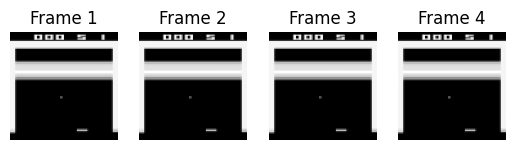

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [6]:
def display_observation(observation):
    C, H, W = observation.shape
    for i in range(C):
        plt.subplot(1, C, i + 1)
        plt.imshow(observation[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Frame {i+1}')
    plt.show()

env = make_env()
state_observation = env.reset()
display_observation(state_observation)
print(env.unwrapped.get_action_meanings())

### The Q function network

Now let's create a neural network to learn the Q function. The input will be a 4x84x84 state as seen above. The output will be Q-values for each of the possible 4 actions.

To process image data, we will use convolutional layers with `nn.Conv2d()`. The architecture will be:
- Convolutional layer with `in_channels=4`, `out_channels=32`, `kernel_size=8`, `stride=4`, `padding=0`
- ReLU activation
- Convolutional layer with `in_channels=32`, `out_channels=64`, `kernel_size=4`, `stride=2`, `padding=0`
- ReLU activation
- Convolutional layer with `in_channels=64`, `out_channels=64`, `kernel_size=3`, `stride=1`, `padding=0`
- ReLU activation
- Flattening of the output into a one dimensional vector
- Linear layer with 512 neurons
- ReLU activation
- Linear layer with `num_actions` neurons

To determine the length of the flattened vector, remember the formula to calculate the output dimensions of a convolutional layer:

$$n_c \times \lfloor \frac{n + 2p - f}{s} + 1 \rfloor \times \lfloor \frac{n + 2p - f}{s} + 1 \rfloor$$

Where $n_c$ is the number of channels, $n$ is the input dimension (height or width), $p$ is the padding, $s$ is the stride and $f$ is the kernel size.


Now lets create a CNN that learns the Q-function.

In [7]:
class QFunction(nn.Module):
    def __init__(self, num_actions):
        super(QFunction, self).__init__()
        self.neural_network = nn.Sequential(
            ## SOLUTION ##
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
            ## SOLUTION ##
            ################################
            #TODO: Define the Q-network architecture
            ################################
        )

    def forward(self, x):
        return self.neural_network(x)

### The replay buffer

In Deep Reinforcement Learning we use a replay buffer to store observed transitions of the form $(s_t, s_{t+1}, a, r, d)$. Where $s_t$ is a state observation, $s_{t+1}$ is the next observed state, $a$ is the action that was taken, $r$ is the received reward and $d$ is the done-flag. 

The replay buffer has a fixed size. Each time we encounter a state transition, we store it in the replay buffer. If its full, the oldest stored transition is pushed out.

Later we sample from the stored transitions to train our Q network.

Each stored transition in the replay buffer contains 8 84x84 greyscale images, 4 for $s_t$ and 4 for $s_{t+1}$. We want to store a lot of transitions to learn from diverse data so we have to think a bit about memory usage when designing the replay buffer. So lets have a look at the data types:

- The environment outputs state observations as 4x84x84 stacked greyscale images with values from 0 to 255 and type `numpy.uint8`
- The Q network takes 4x84x84 stacked greyscale images with normalized values from 0 to 1 and type `torch.float32` as input
- The policy outputs actions as numbers from 0 to 3 and type `int`
- The environment outputs rewards as 0 or 1 and type `float`
- The environment outputs dones as `bool`

For storing transitions, we will cast everything to `numpy.uint8` arrays since it is the smallest numpy data type with only one byte. When sampling, we normalize the states to values from 0 to 1 and cast everything to the desired torch types. To avoid memory fragmentation, we will pre-allocate the whole space for the replay buffer by creating empty numpy arrays of type `np.uint8` by calling `np.empty`.

We also pre-allocate space for the output torch tensors as well as space for temporary arrays that we need when normalizing the states.




In [8]:
class ReplayBuffer:
    def __init__(self, capacity, batch_size, frame_shape, device=None):
        self.capacity = capacity # Maximum number of transitions to store
        self.batch_size = batch_size
        self.current_size = 0
        self.write_index = 0
        self.device = device
        frame_channels, frame_height, frame_width = frame_shape
        
        ## SOLUTION ##
        self.state_buffer       = np.empty((self.capacity, frame_channels, frame_height, frame_width), dtype=np.uint8)
        self.next_state_buffer  = np.empty((self.capacity, frame_channels, frame_height, frame_width), dtype=np.uint8)
        self.action_buffer      = np.empty((self.capacity,), dtype=np.uint8)
        self.reward_buffer      = np.empty((self.capacity,), dtype=np.uint8)
        self.done_buffer        = np.empty((self.capacity,), dtype=np.uint8)
        ## SOLUTION ##
        ################################
        #TODO: Pre-allocate empty numpy arrays for replay buffer data
        #self.state_buffer       = ...
        #self.next_state_buffer  = ...
        #self.action_buffer      = ...
        #self.reward_buffer      = ...
        #self.done_buffer        = ...
        ################################
        
        # Pre-allocate torch tensors for sampling to avoid repeated allocation
        self.sampled_states      = torch.empty((batch_size, frame_channels, frame_height, frame_width), dtype=torch.float32, device=self.device)
        self.sampled_next_states = torch.empty((batch_size, frame_channels, frame_height, frame_width), dtype=torch.float32, device=self.device)
        self.sampled_actions     = torch.empty((batch_size,), dtype=torch.int64, device=self.device)
        self.sampled_rewards     = torch.empty((batch_size,), dtype=torch.float32, device=self.device)
        self.sampled_dones       = torch.empty((batch_size,), dtype=torch.float32, device=self.device)

        # Pre-allocate uint8 temporary conversion buffers (on CPU)
        self.temp_states_uint8      = np.empty((batch_size, frame_channels, frame_height, frame_width), dtype=np.uint8)
        self.temp_next_states_uint8 = np.empty((batch_size, frame_channels, frame_height, frame_width), dtype=np.uint8)
        
        # Pre-allocate float32 temporary conversion buffers (on CPU)
        self.temp_states_np      = np.empty((batch_size, frame_channels, frame_height, frame_width), dtype=np.float32)
        self.temp_next_states_np = np.empty((batch_size, frame_channels, frame_height, frame_width), dtype=np.float32)
        

    def add(self, state, action, reward, next_state, done):
        if torch.is_tensor(state): state = state.detach().cpu().numpy().astype(np.uint8)
        if torch.is_tensor(next_state): next_state = next_state.detach().cpu().numpy().astype(np.uint8)
        if torch.is_tensor(action):  action = action.detach().cpu().item()
        if torch.is_tensor(reward):  reward = reward.detach().cpu().item()
        if torch.is_tensor(done):    done = done.detach().cpu().item()
        buffer_index = self.write_index
        self.state_buffer[buffer_index]      = state
        self.next_state_buffer[buffer_index] = next_state
        self.action_buffer[buffer_index]     = np.uint8(action)
        self.reward_buffer[buffer_index]     = np.uint8(reward)
        self.done_buffer[buffer_index]       = np.uint8(done)
        
        self.write_index = (buffer_index + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, device=None):
        sample_indices = np.random.randint(0, self.current_size, size=self.batch_size)
        
        # Normalize and copy states to preallocated float32 arrays
        np.take(self.state_buffer, sample_indices, axis=0, out=self.temp_states_uint8) # take from buffer and push to uint8 temporary conversion buffer
        np.take(self.next_state_buffer, sample_indices, axis=0, out=self.temp_next_states_uint8)
        np.divide(self.temp_states_uint8, 255.0, out=self.temp_states_np) # divide by 255.0 and push to float32 temporary conversion buffer
        np.divide(self.temp_next_states_uint8, 255.0, out=self.temp_next_states_np)
        
        # Copy numpy data into pre-allocated torch buffers
        self.sampled_states.copy_(torch.from_numpy(self.temp_states_np).to(self.device)) # take from float32 temporary conversion buffer
        self.sampled_next_states.copy_(torch.from_numpy(self.temp_next_states_np).to(self.device))
        self.sampled_actions.copy_(torch.from_numpy(self.action_buffer[sample_indices]).long().to(self.device))
        self.sampled_rewards.copy_(torch.from_numpy(self.reward_buffer[sample_indices]).to(self.device))
        self.sampled_dones.copy_(torch.from_numpy(self.done_buffer[sample_indices]).to(self.device))
        return self.sampled_states, self.sampled_actions, self.sampled_rewards, self.sampled_next_states, self.sampled_dones
    
    def filled_percentage(self):
        return self.size()*100/self.capacity

    def size(self):
        return self.current_size
    
    def __len__(self):
        return self.current_size


### The epsilon-greedy policy

Now, let's implement a simple epsilon-greedy policy for action selection. When calling the function `select_action()`, the Q function and a state is passed. With a probability of `epsilon` a random action is sampled from the action space and returned. Otherwise we select:

$$ a_t = \max_a Q(s_t, a)$$

Meaning, we select the index of the maximum Q-value that our Q function outputs for a state.

In [9]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon, epsilon_min, epsilon_decay, action_space):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.action_space = action_space

    def select_action(self, q_function, state):
        ## SOLUTION ##
        if np.random.random() < self.epsilon:
            return self.action_space.sample() #exploration: random action
        else:
            with torch.no_grad(): # don't calculate gradients for this inference
                state = torch.tensor(state, dtype=torch.float32)
                state = state.unsqueeze(0) #add batch dimension
                q_values = q_function(state)
                action = torch.argmax(q_values).item() #exploitation
                return action
        ## SOLUTION ##
        ################################
        # TODO: Implement the epsilon-greedy action selection policy
        # if ...: # exploration
        #    ...
        #    return action
        # else: # exploitation
        #    with torch.no_grad():
        #        state = torch.tensor(state, dtype=torch.float32)
        #        state = state.unsqueeze(0) #add batch dimension
        #        ...
        #        return action
        ################################
        
    def update_epsilon(self):
        #self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

    def get_epsilon(self):
        return self.epsilon

### Helper functions

Let's create a helper function for live plotting.

In [10]:
def plot_info(rewards, q_maxs, q_values, epsilon, replay_buffer_filled_percentage):
    moving_average_window = 100
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))

    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.title("Episode Rewards")
    plt.plot(rewards, label="Reward per Episode", alpha=0.6)
    if len(rewards) >= moving_average_window:
        movavg = np.convolve(rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
        movavg = np.concatenate([np.full(moving_average_window-1, np.nan), movavg])
        plt.plot(movavg, label=f"{moving_average_window}-Episode Moving Avg")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid()
    plt.legend()

    # Plot Q mean
    plt.subplot(2, 2, 2)
    plt.title("Max. Q-value")
    plt.plot(q_maxs, label="Q Max", alpha=0.6)
    if len(q_maxs) >= moving_average_window:
        movavg = np.convolve(q_maxs, np.ones(moving_average_window)/moving_average_window, mode='valid')
        movavg = np.concatenate([np.full(moving_average_window-1, np.nan), movavg])
        plt.plot(movavg, label=f"{moving_average_window}-Episode Moving Avg")
    plt.xlabel("Episode")
    plt.grid()
    plt.legend()
 
    plt.subplot(2, 2, 4)
    plt.axis("off")  # Hide axes
    q_values = q_values.flatten()
    q_str = ", ".join([f"{q:.2f}" for q in q_values.cpu().tolist()])
    text = f"Epsilon: {epsilon:.3f}\n" \
           f"Last Episode Reward: {rewards[-1]:.1f}\n" \
           f"Q-Values: {q_str}\n" \
           f"Replay Buffer Filled: {replay_buffer_filled_percentage:.1f}%\n"
    plt.text(0, 1, text, fontsize=12, va="top", ha="left")

    plt.tight_layout()
    plt.show()

Traning the DQN agent can take a long time, especially if no GPU is aviliable. The following helper functions save trained models at checkpoints during training and load pre-trained models.

In the folder `checkpoints/pretrained` you can find pre-trained models for the Q function. They were saved at every 1000 training episodes. By moving a pre-trained model into the `load` folder, you can load the pre-trained model and train it for the remaining episodes. You will see the original plots of this models training procedure and you can seamlessly continue its training.

In [11]:
def save_checkpoint(model, optimizer, episode, steps, rewards_per_episode, q_maxs):
    path = os.path.join(SAVED_PATH_STR, f'model_episode_{episode}_{steps}.pt')
    torch.save({
        'episode': episode,
        'steps': steps,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'rewards_per_episode': rewards_per_episode,
        'q_maxs': q_maxs
    }, path)
    print(f"Checkpoint saved: {path}")
    logging.info(f"Checkpoint saved: {path}")

def load_latest_checkpoint(model, device=None):
    epsilon_start = 1.0
    if not os.path.exists(LOAD_PATH_STR):
        print(f"Checkpoint directory does not exist: {LOAD_PATH_STR}")
        logging.info(f"Checkpoint directory does not exist: {LOAD_PATH_STR}")
        return model, None, 0, 0, [], []    # Start fresh
    checkpoints = [f for f in os.listdir(LOAD_PATH_STR) if f.endswith('.pt')]
    if not checkpoints:
        print("No checkpoint files found.")
        logging.info("No checkpoint files found.")
        return model, None, 0, 0, [], []    # Start fresh

    valid_files = []
    for f in checkpoints:
        match = re.match(r'model_episode_(\d+)_(\d+)\.pt', f)
        if match:
            episode = int(match.group(1))
            steps = int(match.group(2))
            valid_files.append((episode, steps, f))

    if not valid_files:
        print("No valid checkpoint filenames matched the pattern.")
        logging.info("No valid checkpoint filenames matched the pattern.")
        return model, None, 0, 0, [], []   

    # Sort by episode and steps, then take the latest
    latest = max(valid_files, key=lambda x: (x[0], x[1]))
    latest_episode, latest_steps, latest_file = latest
    path = os.path.join(LOAD_PATH_STR, latest_file)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint loaded: {path}")
    logging.info(f"Checkpoint loaded: {path}")
    return model, checkpoint['optimizer_state_dict'], checkpoint['episode'], checkpoint['steps'], checkpoint['rewards_per_episode'], checkpoint['q_maxs']  

### The training loop

The training loop is the main part of our algorithm. We train the Q function on the loss:

$$L(\theta) = \mathbb{E} [(y_t - Q(s_t, a_t; \theta_t))^2]$$

Where $\theta_t$ are the parameters of the Q function network and $y_t$ is the target Q value. For calculating the loss, you can use the `SmoothL1Loss`.

The target $y_t$ can be calculated with:

$$y_t = \begin{cases}
r_t & \text{if } s_{t+1} \text{ is terminal}\\
r_t + \gamma \max_a Q(s_{t+1}, a) & \text{if } s_{t+1} \text{ is not terminal}
\end{cases}$$

Where $r$ is the observed reward.

As you can see, we use the Q function to calculate its own training target. With each training update to the Q function, the training target will therefore change as well. This destabelizes our training since we can't train towards a stable target.

To aliviate this, we use two Q function networks: 
- A general Q function network $Q$
- A Q function network to compute the targets $Q'$

In reality, $Q'$ is a copy of $Q$. We update this copy after every a certain number of training step using Exponential Moving Average (EMA). In EMA, each parameter $\theta'$ of $Q'$ network is updated with:

$$\theta' \leftarrow \mu \theta' + (1 - \mu)\theta$$

Where $\theta$ is the corresponding parameter of the $Q$ network and $\mu$ is a smoothing factor.

The size of the replay buffer has a large impact on our training performance. The original paper used a replay buffer with a capacity of 1 million transitions. Each transition stores two 4x84x84 stacked frames where each value is a `np.uint8` with the size of 1 byte. One million transitions would use at least $84 \times 84 \times 8 \times 1000000 \approx 52\text{ Giga Byte}$ of memory! 

We reduce the replay buffer capacity down to 50000 transitions, which should only use around 2.7 GB of memory. If your systems allows for more, feel free to increase the size but make sure to leave some space for the other variables.

Before starting the training we take 50000 warmup steps where we don't learn in order to initially fill up the replay buffer. You don't need to increase the number of warmup steps when increasing the replay buffer capacity.



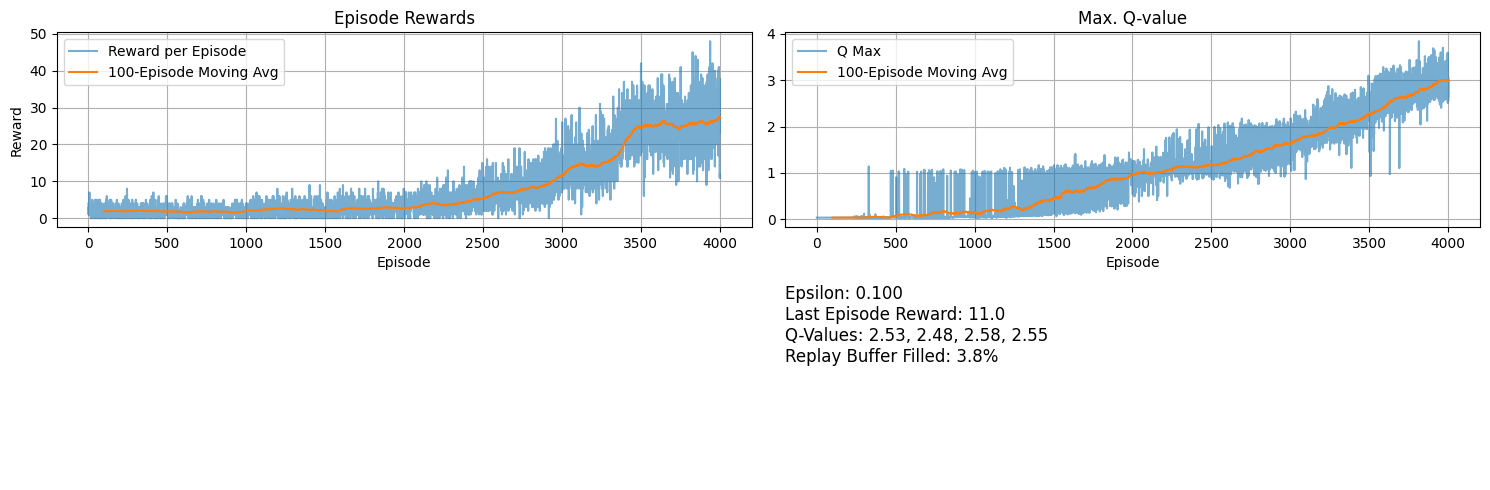

4004it [00:05,  1.44s/it]

Total RAM: 16.51 GB
Available: 11.20 GB
Used: 5.06 GB


4004it [00:07,  1.89s/it]


KeyboardInterrupt: 

In [32]:
num_episodes = 5_000
batch_size = 32
gamma = 0.99 # discount factor
mu = 0.95 # moving average coefficient for target network update
target_update_frequency = 100
learning_rate = 0.00025
replay_buffer_size = 50_000
warmup_steps = 50_000 # to fill replay buffer before training starts
epsilon_min = 0.1
epsilon_decay = (1.0 - 0.1) / 1_000_000 # reduce exploration over time
epsilon_start = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_maxs = []
rewards_per_episode = []

q = QFunction(4)
q, optimizer_state_dict, last_saved_episode, last_saved_steps, rewards_per_episode, q_maxs = load_latest_checkpoint(q, device=device)

epsilon_start = max(epsilon_start - epsilon_decay*last_saved_steps, epsilon_min)

q_target = QFunction(4)
q_target.load_state_dict(q.state_dict()) # copy initial parameters from q to q_target
q.to(device)
q_target.to(device)

optimizer = optim.RMSprop(q.parameters(), lr=learning_rate) # only feed q parameters to the optimizer
if optimizer_state_dict is not None:
    optimizer.load_state_dict(optimizer_state_dict)

q_target.eval() # set target network to evaluation mode

policy = EpsilonGreedyPolicy(epsilon=epsilon_start, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, action_space=env.action_space)
replay_buffer = ReplayBuffer(capacity=replay_buffer_size, batch_size=batch_size, frame_shape=(4, 84, 84), device=device)

steps = 0

q_values_check_state = torch.zeros((4), device=device)

for episode in trange(last_saved_episode, num_episodes, initial=last_saved_episode):
    state = env.reset()
    done = False
    total_reward = 0
    if steps > 0:
        # Each episode, we sample a state from the replay buffer and compute the Q-values to monitor their evolution
        check_states, actions, rewards, next_states, dones = replay_buffer.sample(device=device)
        check_state = check_states[0]
        with torch.no_grad():
            q_values_check_state = q(check_state.unsqueeze(0))
            q_maxs.append(q_values_check_state.max().item())
    while not done:
        q.eval()
        state_normalized = torch.tensor(state, device=device, dtype=torch.float32) / 255.0
        ## SOLUTION ##
        action = policy.select_action(q, state_normalized)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        ## SOLUTION ##
        ################################
        # TODO: Select an action using the policy, perform the action in the environment, 
        # observe the result and store the transition in the replay buffer.
        
        ################################
        
        state = next_state # transition to next state
        total_reward += reward
        steps += 1

        if steps > warmup_steps and replay_buffer.size() >= batch_size:
            q.train()
            states, actions, rewards, next_states, dones = replay_buffer.sample(device=device)
            q_values = q(states).gather(1, actions.unsqueeze(1)) # calculate Q-values for batch of selected actions
            with torch.no_grad():
                ## SOLUTION ##
                next_q_values = q_target(next_states).max(dim=1)[0]
                target_q = rewards + (1 - dones)*gamma*next_q_values # calculate target for batch using q_target
                ## SOLUTION ##
                ################################
                # TODO: Compute the target Q-values
                
                ################################
            q_values = q_values.squeeze()
            ## SOLUTION ##
            loss = nn.SmoothL1Loss()(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            policy.update_epsilon()
            #SOLUTION ##
            ##############################
            # TODO: Compute the loss, apply the optimizer and update epsilon
            
            ###############################
            if steps % target_update_frequency == 0:
                with torch.no_grad():
                    for param, target_param in zip(q.parameters(), q_target.parameters()):
                        ## SOLUTION ##
                        target_param.data.mul_(mu)
                        target_param.data.add_((1-mu) * param.data)
                        ## SOLUTION ##
                        #################################
                        # TODO: Update the target network parameters using EMA
                        # Hint: Access a parameters value using param.data and use target_param.data.mul_() for multiplication and target_param.data.add_() for addition.
                        
                        #################################
    if episode % 1000 == 0 and episode > 0:
        save_checkpoint(q, optimizer, last_saved_episode + episode, last_saved_steps + steps, rewards_per_episode, q_maxs)



    rewards_per_episode.append(total_reward)
    plot_info(rewards_per_episode, q_maxs, q_values_check_state, policy.get_epsilon(), replay_buffer.filled_percentage())
    mem = psutil.virtual_memory()
    print(f"Total RAM: {mem.total / 1e9:.2f} GB")
    print(f"Available: {mem.available / 1e9:.2f} GB")
    print(f"Used: {mem.used / 1e9:.2f} GB")




Lets look at how our agent plays the game

Checkpoint loaded: checkpoints/load/model_episode_5000_2728648.pt


Checkpoint loaded: checkpoints/load/model_episode_5000_2728648.pt


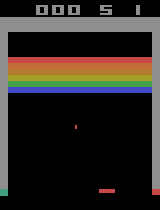

In [31]:
q, _, _, _, _, _ = load_latest_checkpoint(q, device=device)
env = make_env(render_mode="rgb_array")
frames = []
obs = env.reset()
done = False
truncated = False

def select_action(obs):
    obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device) / 255.0
    with torch.no_grad():
        q_values = q(obs_t)
    return q_values.argmax().item()

while not done:
    frame = env.render()
    frames.append(frame)
    action = select_action(obs)
    obs, reward, done, info = env.step(action)

env.close()
gif_path = VIDEOS_PATH_STR + "/breakout_dqn_play.gif"
imageio.mimsave(gif_path, frames, fps=30)
display(Image(filename=gif_path))

## Bonus: Overestimation bias and Double-DQN

DQN models suffer from overestimation bias. This happens when calculating the targets:

$$y_t = \begin{cases}
r_t & \text{if } s_{t+1} \text{ is terminal}\\
r_t + \gamma \max_a Q(s_{t+1}, a) & \text{if } s_{t+1} \text{ is not terminal}
\end{cases}$$

The problem is that Q(s,a) does not provide the true value of an action in a state but a noisy estimate because it is just a trained model. If we always take the max of a noisy estimate, we overestimate on expectation!

Here is some code to explain this and how Double DQN solves this.

Suppose we are in a state s and have two possible actions a1 and a2. Both actions have a true value of 1, i.e., an expected future reward of 1.

Since our model of Q(s, a) is noisy, we represent the output of our model as random variables around the true value: q_a1 ~ N(1, 0.3) and q_a2 ~ N(1, 0.3)

 Let's simulate what DQN does:


In [20]:
# Define two random variables and draw 1000 samples from each
q_a1_samples = np.random.normal(1, 0.3, 1000)
q_a2_samples = np.random.normal(1, 0.3, 1000)

# Now we choose the maximum between each pair of samples
max_q_a1_q_a2 = np.maximum(q_a1_samples, q_a2_samples)

# Estimate the expectation over this E[max(X, Y)]
dqn_exp = np.mean(max_q_a1_q_a2)
print(f"DQN estimate: {dqn_exp}")
deviation = abs(dqn_exp - 1)*100
print(f"Deviation from true value: {deviation}%")

DQN estimate: 1.1686683078996243
Deviation from true value: 16.866830789962428%


What we really want is to choose the action with the maximum expected value. In our case both of them have the same true value of 1 so the expected output of our model of Q(s,a) should also be around 1:



In [21]:
expectation_q_a1 = np.mean(q_a1_samples)
expectation_q_a2 = np.mean(q_a2_samples)

dqn_exp_desired = max(expectation_q_a1, expectation_q_a2)
print(f"Desired DQN estimate: {dqn_exp_desired}")
deviation = abs(dqn_exp_desired - 1)*100
print(f"Deviation from true value: {deviation}%")

Desired DQN estimate: 1.0068492637988216
Deviation from true value: 0.6849263798821559%


As we can see, our DQN estimate is quite far from the desired estimate. It is overestimating.

Double DQN fixes this by using the `q`model to select the best action and then calculate the value of that action with the `q_target` network.

In our minimal example this is expressed with first collecting the indices of the maximum between each pair of samples, then drawing new samples and calculate the expectaiton of the new sample values at the position of the previously connected indices. Drawing new samples disconnects the `mean` operator from the `max` operator and is equivalent to what Double DQN does.

In [22]:
Z = np.stack([q_a1_samples, q_a2_samples])
argmax_indices = np.argmax(Z, axis=0)
q_a1_samples_new = np.random.normal(1, 0.2, 1000)
q_a2_samples_new = np.random.normal(1, 0.2, 1000)
max_values = np.where(argmax_indices == 0, q_a1_samples_new, q_a2_samples_new)
double_dqn_exp = np.mean(max_values)
print(f"Double DQN estimate: {double_dqn_exp}")
deviation = abs(double_dqn_exp - 1)*100
print(f"Deviation from true value: {deviation}%")

Double DQN estimate: 0.9920160796391934
Deviation from true value: 0.798392036080664%


As you can see (hopefully), the estimate is now much closer to the actual mean value of 1.

Feel free to try to convert your DQN algorithm into a Double-DQN algorith. This only requires a few lines of code in the training loop.